In [1]:
#Importación de librerías he escogido un conjunto de ellas que he visto en documentación que me pueden servir.
import pandas as pd   
import numpy as np    
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, fbeta_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve


In [2]:
#En primer lugar, vemos que contiene el dataset y sacamos un ejemplillo de los campos que tenemos.
df = pd.read_csv('clientes.csv')
df.head()

,ID_CLIENTE,N1_DESC_CORTA,ANTIGUEDAD,SEGMENTO_ESTRATEGICO,SW_CLIENTE_PREFERENTE,SW_REEMBOLSO,DIGITAL,SW_RETENIBLE,SW_ESTRATEGICO,EDAD,PRIMA,PORC_COASEGURO,TIPO_SOCIO,TIEMPO,INTERACCIONES,TMO,NOCITA
0,7230814.0,CITA,2.61,BRONCE,N,N,0.0,S,NaN,40.0,498.60,1.0,Pymes,192.0,1.0,192.0,0.0
1,3881707.0,CITA,36.78,BRONCE,N,N,0.0,S,NaN,37.0,1235.52,1.0,Particular,732.0,2.0,366.0,1.0
2,300345.0,CITA,31.00,PLATINO,N,N,0.0,S,NaN,86.0,2853.36,1.0,Colectivo Abierto,317.0,1.0,317.0,0.0
3,6933807.0,CITA,3.20,BRONCE,N,C,0.0,S,NaN,44.0,0.00,1.0,Pymes,284.0,1.0,284.0,0.0
4,1127549.0,CITA,56.70,ORO,N,C,0.0,S,NaN,57.0,0.00,1.0,Particular,2732.0,4.0,683.0,1.0


In [3]:
#Tras tener claro los campos que contiene el dataset, vamos a realizar un resumen de los datos.
# sacamos por pantalla con el print los valores elegidos 
print ('Filas     : ', df.shape[0])
print ('Columnas  : ', df.shape[1])
print ('campos', df.columns.tolist())
print ('nulos :  ', df.isnull().sum().values.sum())
print ('valores únicos :  \n', df.nunique())

Filas     :  65479
Columnas  :  17
campos ['ID_CLIENTE', 'N1_DESC_CORTA', 'ANTIGUEDAD', 'SEGMENTO_ESTRATEGICO', 'SW_CLIENTE_PREFERENTE', 'SW_REEMBOLSO', 'DIGITAL', 'SW_RETENIBLE', 'SW_ESTRATEGICO', 'EDAD', 'PRIMA', 'PORC_COASEGURO', 'TIPO_SOCIO', 'TIEMPO', 'INTERACCIONES', 'TMO', 'NOCITA']
nulos :   54334
valores únicos :  
 ID_CLIENTE               42322
N1_DESC_CORTA                1
ANTIGUEDAD                1244
SEGMENTO_ESTRATEGICO         6
SW_CLIENTE_PREFERENTE        2
SW_REEMBOLSO                 3
DIGITAL                      2
SW_RETENIBLE                 2
SW_ESTRATEGICO               1
EDAD                       103
PRIMA                    15351
PORC_COASEGURO               2
TIPO_SOCIO                   5
TIEMPO                    4818
INTERACCIONES               20
TMO                       4378
NOCITA                       2
dtype: int64


In [4]:
#Mostramos los campos con el tipo y sus valores
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65479 entries, 0 to 65478
Data columns (total 17 columns):
ID_CLIENTE               65479 non-null float64
N1_DESC_CORTA            65479 non-null object
ANTIGUEDAD               65479 non-null float64
SEGMENTO_ESTRATEGICO     65476 non-null object
SW_CLIENTE_PREFERENTE    65479 non-null object
SW_REEMBOLSO             65479 non-null object
DIGITAL                  65479 non-null float64
SW_RETENIBLE             65479 non-null object
SW_ESTRATEGICO           12854 non-null object
EDAD                     65479 non-null float64
PRIMA                    65479 non-null float64
PORC_COASEGURO           65479 non-null float64
TIPO_SOCIO               65479 non-null object
TIEMPO                   64626 non-null float64
INTERACCIONES            65479 non-null float64
TMO                      64626 non-null float64
NOCITA                   65479 non-null float64
dtypes: float64(10), object(7)
memory usage: 8.5+ MB


In [5]:
#Eliminamos los campos que no vamos a necesitar a la hora de modelar
df= df.drop(['ID_CLIENTE', 'N1_DESC_CORTA','INTERACCIONES'], axis=1)

In [7]:
#Transformamos los campos nocita,digital y porc_coaseguro en categoricos para poder tratarlos mejor y quitamos los nulos del campo sw_estrategico. además sustituimos los nulos o ceros
#de los campos TMO, Tiempo y Prima
df['NOCITA'] = df['NOCITA'].replace({1:'Yes',0:'No'})
df['DIGITAL'] = df['DIGITAL'].replace({1:'Yes',0:'No'})
df['PORC_COASEGURO'] = df['PORC_COASEGURO'].replace({1:'Yes',0.5:'No'})
df['SW_ESTRATEGICO'] = df['SW_ESTRATEGICO'].replace(np.nan,'N')
df['TIEMPO'] = df['TIEMPO'].replace(np.nan,df['TIEMPO'].mean())
df['TMO'] = df['TMO'].replace(np.nan,df['TMO'].mean())
df['PRIMA'] = df['PRIMA'].replace(np.nan,df['PRIMA'].mean())


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65479 entries, 0 to 65478
Data columns (total 14 columns):
ANTIGUEDAD               65479 non-null float64
SEGMENTO_ESTRATEGICO     65476 non-null object
SW_CLIENTE_PREFERENTE    65479 non-null object
SW_REEMBOLSO             65479 non-null object
DIGITAL                  65479 non-null object
SW_RETENIBLE             65479 non-null object
SW_ESTRATEGICO           65479 non-null object
EDAD                     65479 non-null float64
PRIMA                    65479 non-null float64
PORC_COASEGURO           65479 non-null object
TIPO_SOCIO               65479 non-null object
TIEMPO                   65479 non-null float64
TMO                      65479 non-null float64
NOCITA                   65479 non-null object
dtypes: float64(5), object(9)
memory usage: 7.0+ MB


In [8]:
#Tras formatear los distintos campos podemos describir todos los campos numericos que incorpora el dataset
df.describe()

,ANTIGUEDAD,EDAD,PRIMA,TIEMPO,TMO
count,65479.000000,65479.000000,65479.000000,6.547900e+04,6.547900e+04
mean,15.939124,49.110478,771.809794,2.321906e+05,1.441049e+05
std,13.626471,20.784182,869.989259,1.093071e+07,5.170790e+06
min,0.000000,0.000000,0.000000,6.000000e+00,6.000000e+00
25%,4.700000,37.000000,0.000000,2.240000e+02,2.210000e+02
50%,11.700000,50.000000,574.800000,4.280000e+02,3.900000e+02
75%,24.360000,65.000000,1032.980000,1.098000e+03,7.500000e+02
max,70.860000,120.000000,10683.720000,1.506458e+09,3.753277e+08


No     63900
Yes     1579
Name: DIGITAL, dtype: int64


Text(0.5, 1.0, 'Clientes digitales')

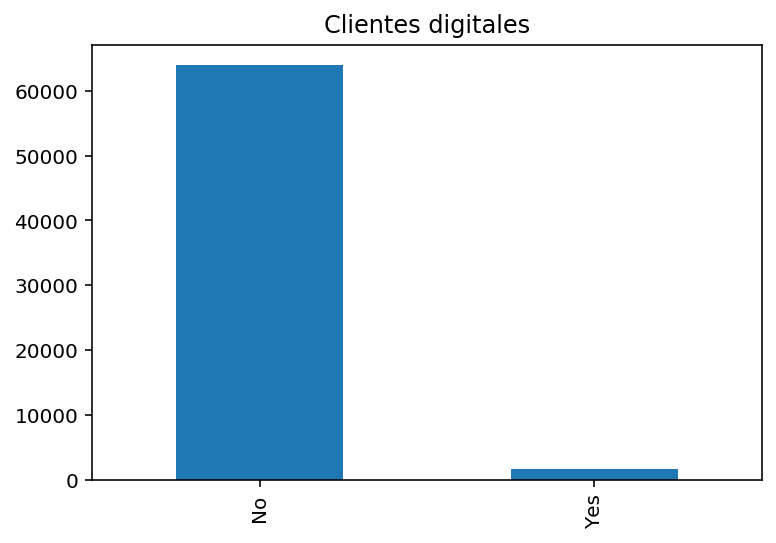

In [9]:
# A continuación vemos la cantidad de clientes digitales que hay en el dataset.
# como se puede ver hay bastante mas NO clientes digitales que los que si lo son
print(df.DIGITAL.value_counts())
df['DIGITAL'].value_counts().plot('bar').set_title('Clientes digitales')

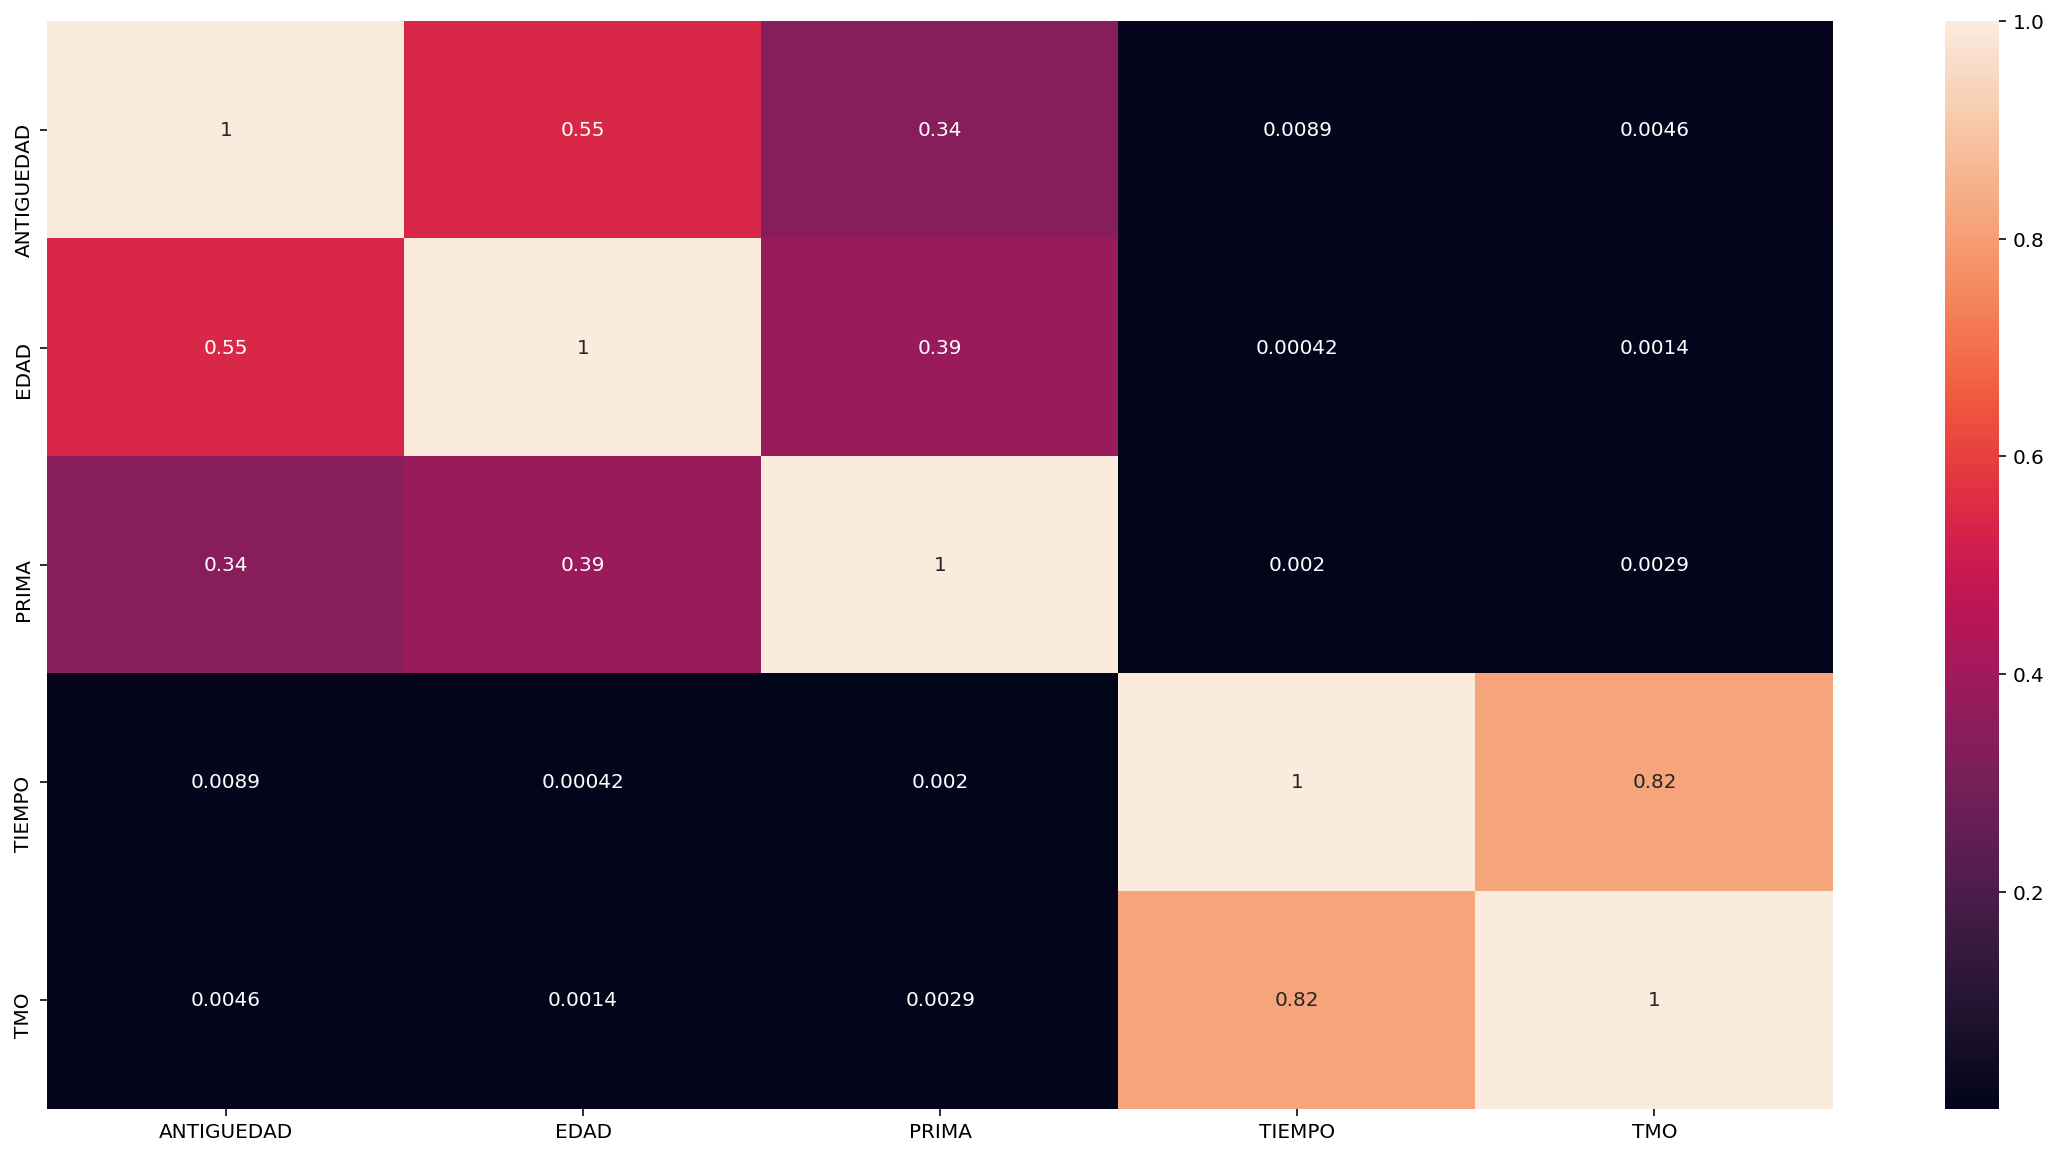

In [10]:
#Mediante la función corr imprimimos las correlaciones de los valores numéricos.
def show_correlations(dataframe, show_chart = True):
    fig = plt.figure(figsize = (20,10))
    corr = dataframe.corr()
    if show_chart == True:
        sns.heatmap(corr, 
                    xticklabels=corr.columns.values,
                    yticklabels=corr.columns.values,
                    annot=True)
    return corr

correlation_df = show_correlations(df,show_chart=True)

Análisis visual de las variables numéricas para entender como están repartidas

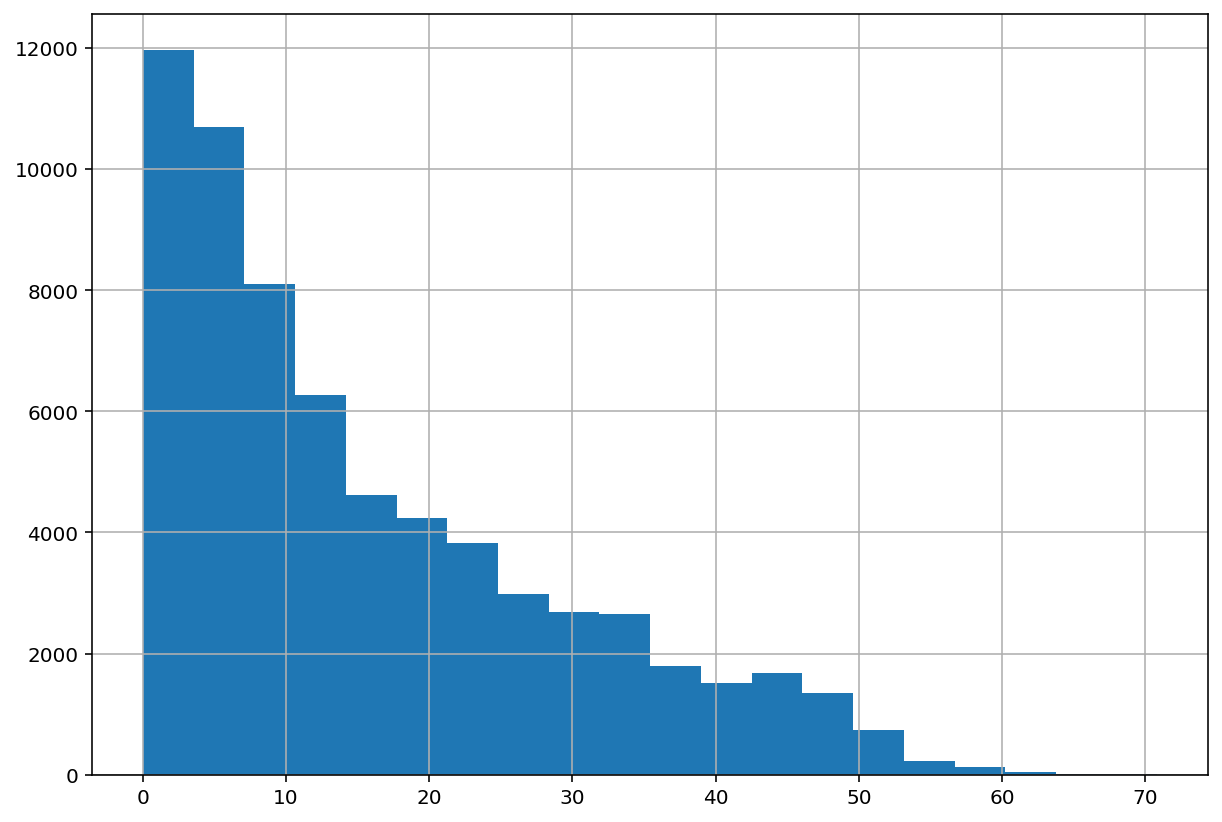

In [11]:
# de esta manera vemos las variables num en grágica para visualizarlas mejor
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
df['ANTIGUEDAD'].hist(bins=20, figsize=(10, 7), ax=ax)


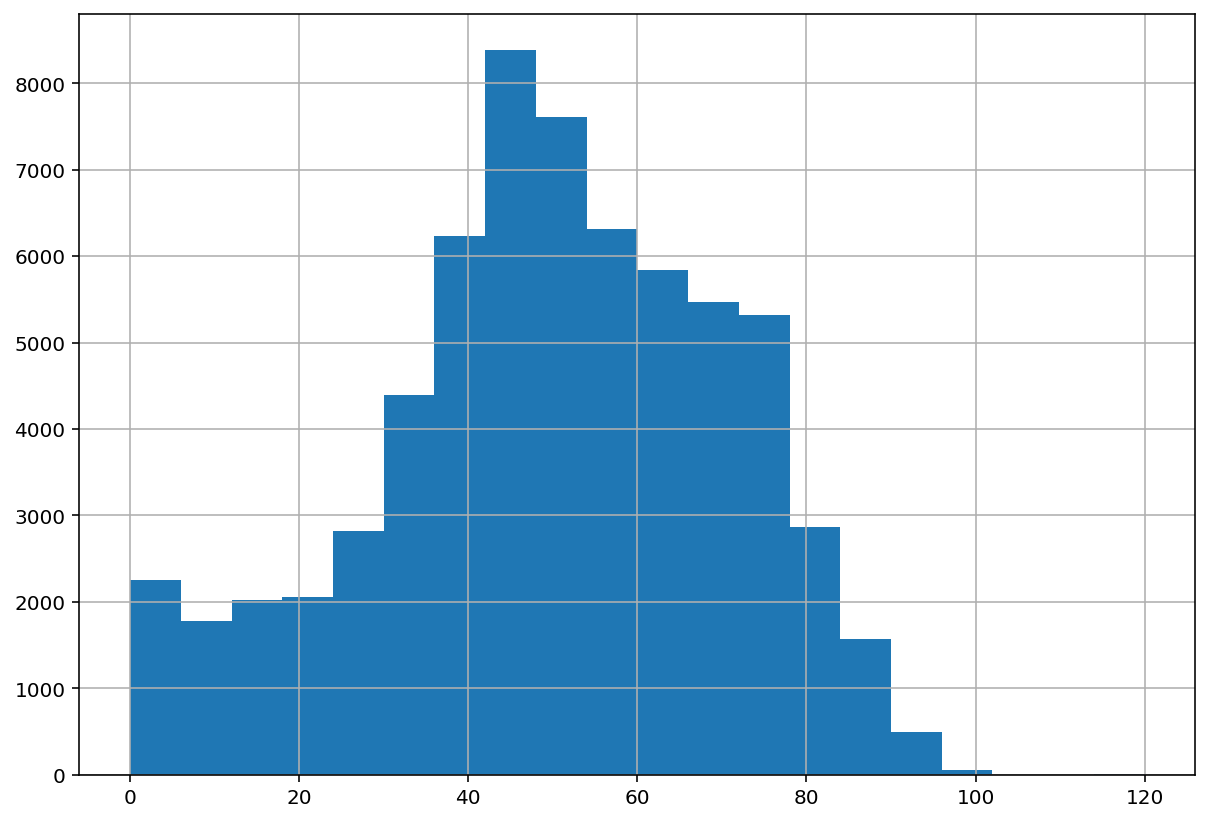

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
df['EDAD'].hist(bins=20, figsize=(10, 7), ax=ax)

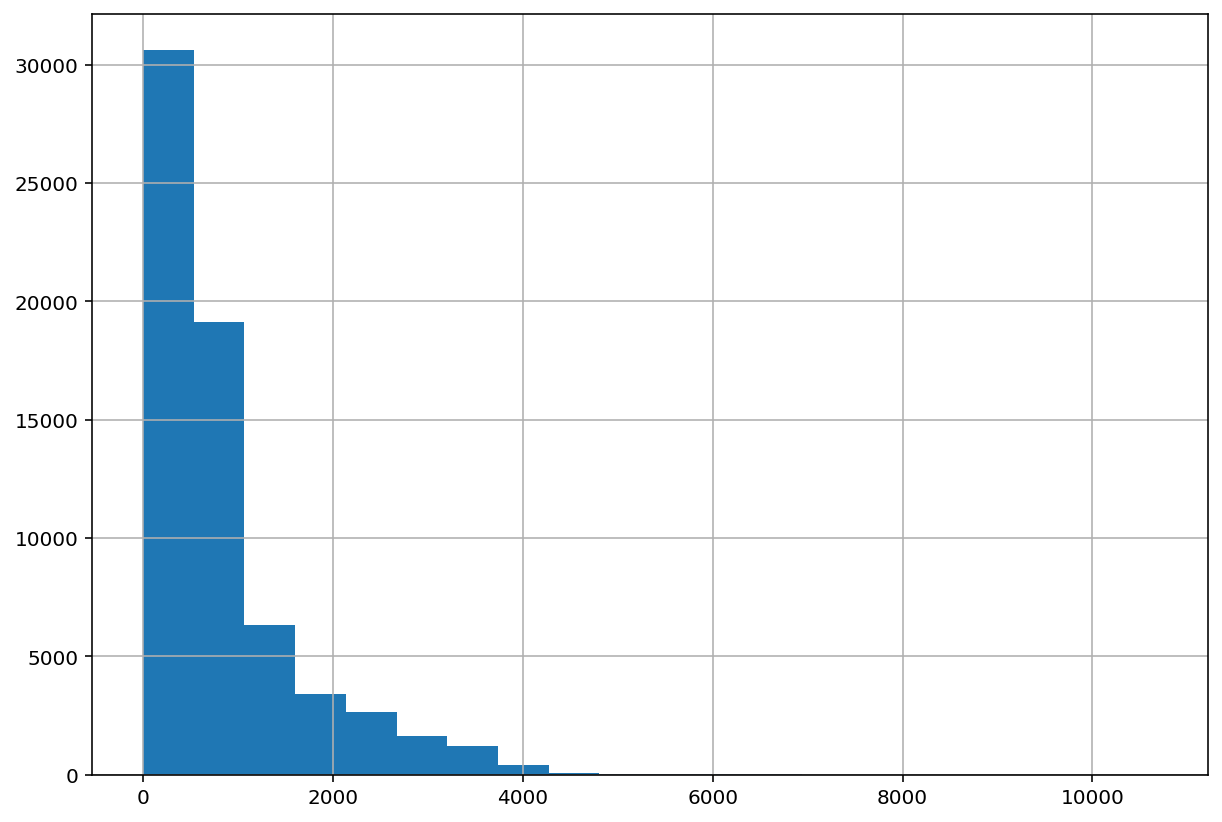

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
df['PRIMA'].hist(bins=20, figsize=(10, 7), ax=ax)

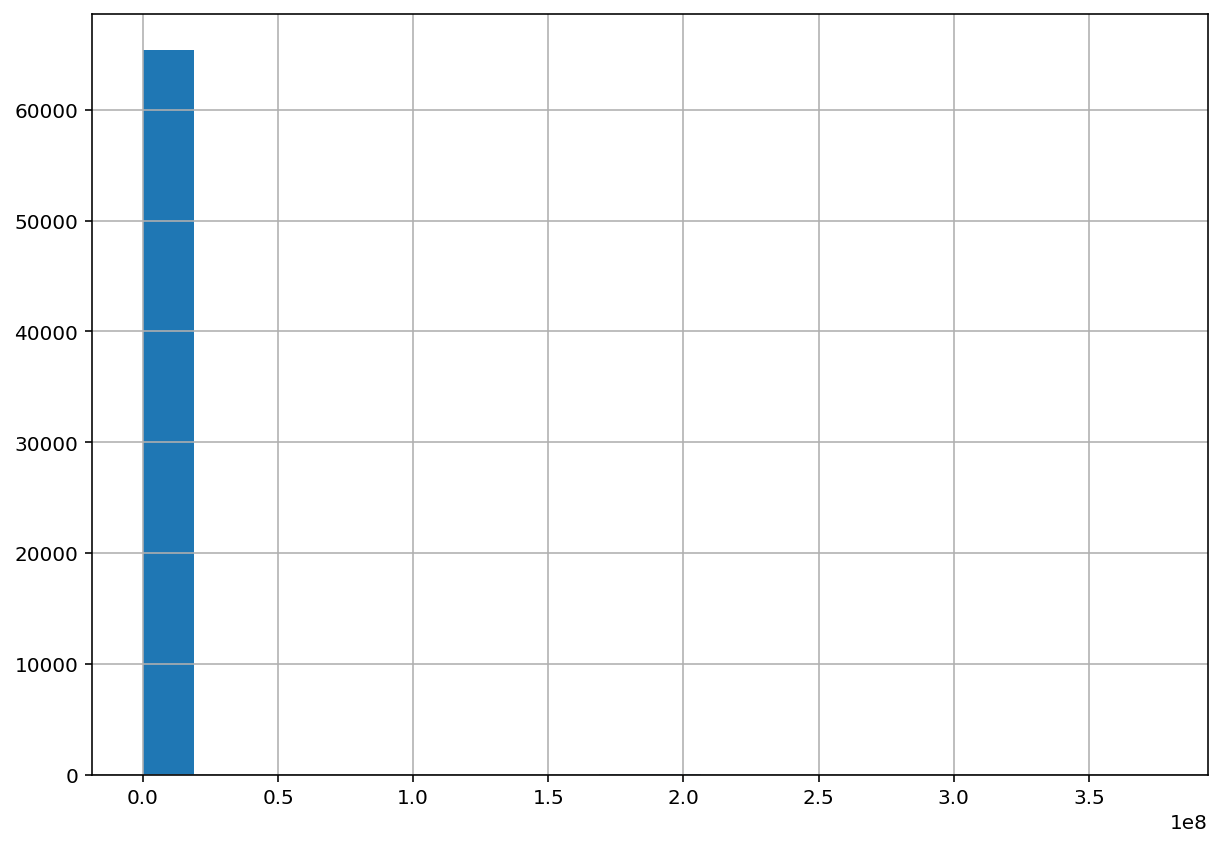

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
df['TMO'].hist(bins=20, figsize=(10, 7), ax=ax)

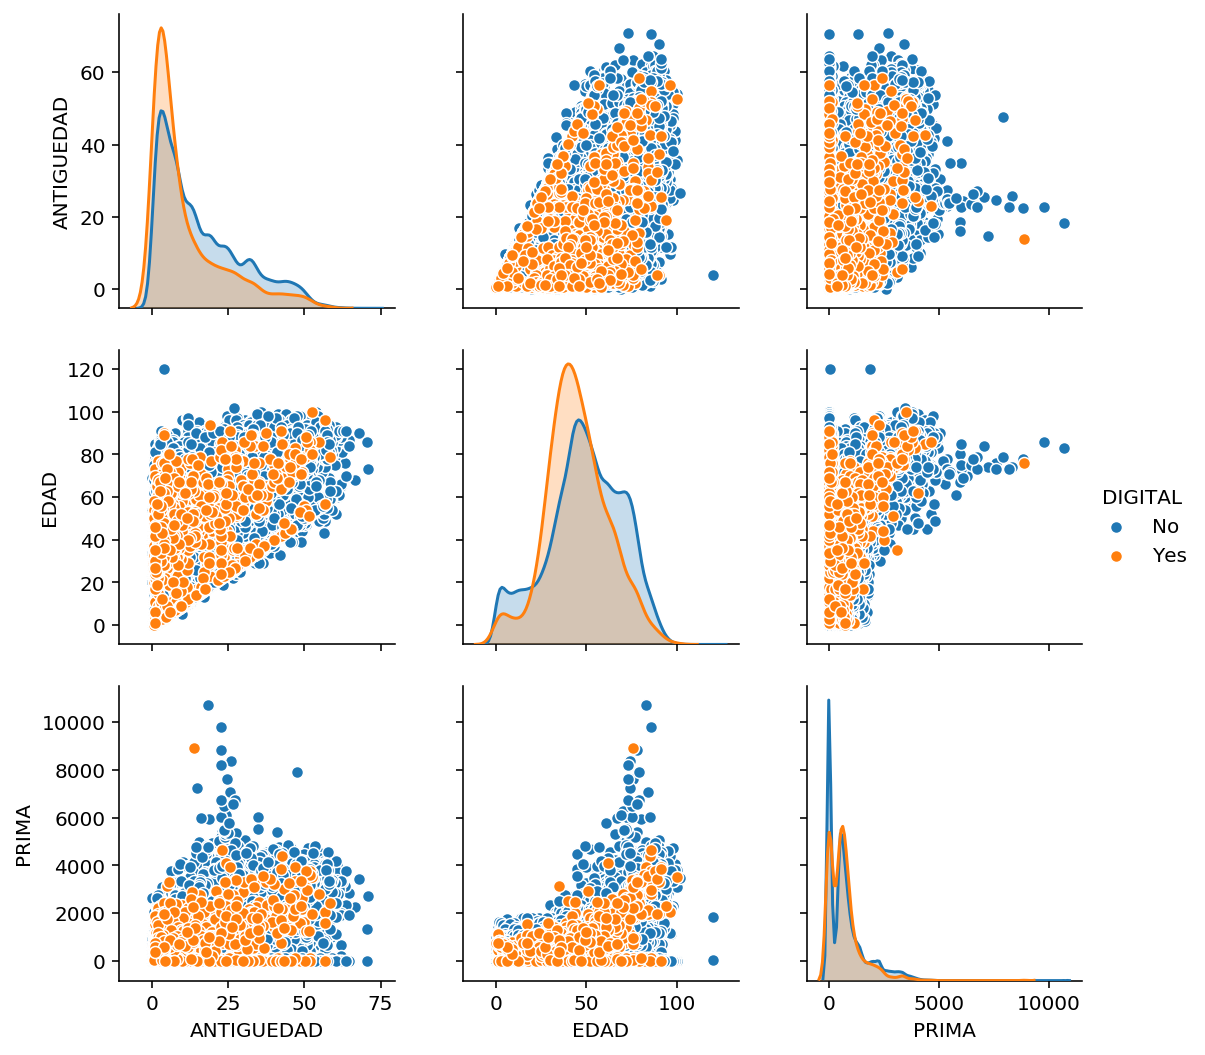

In [15]:
#Utilizando la función pairplot nos permite visualizar a través de los gráficos donde hay digitalización en las distintas variables numericas
sns.pairplot(df[['ANTIGUEDAD', 'EDAD', 'PRIMA', 'DIGITAL']], hue='DIGITAL')

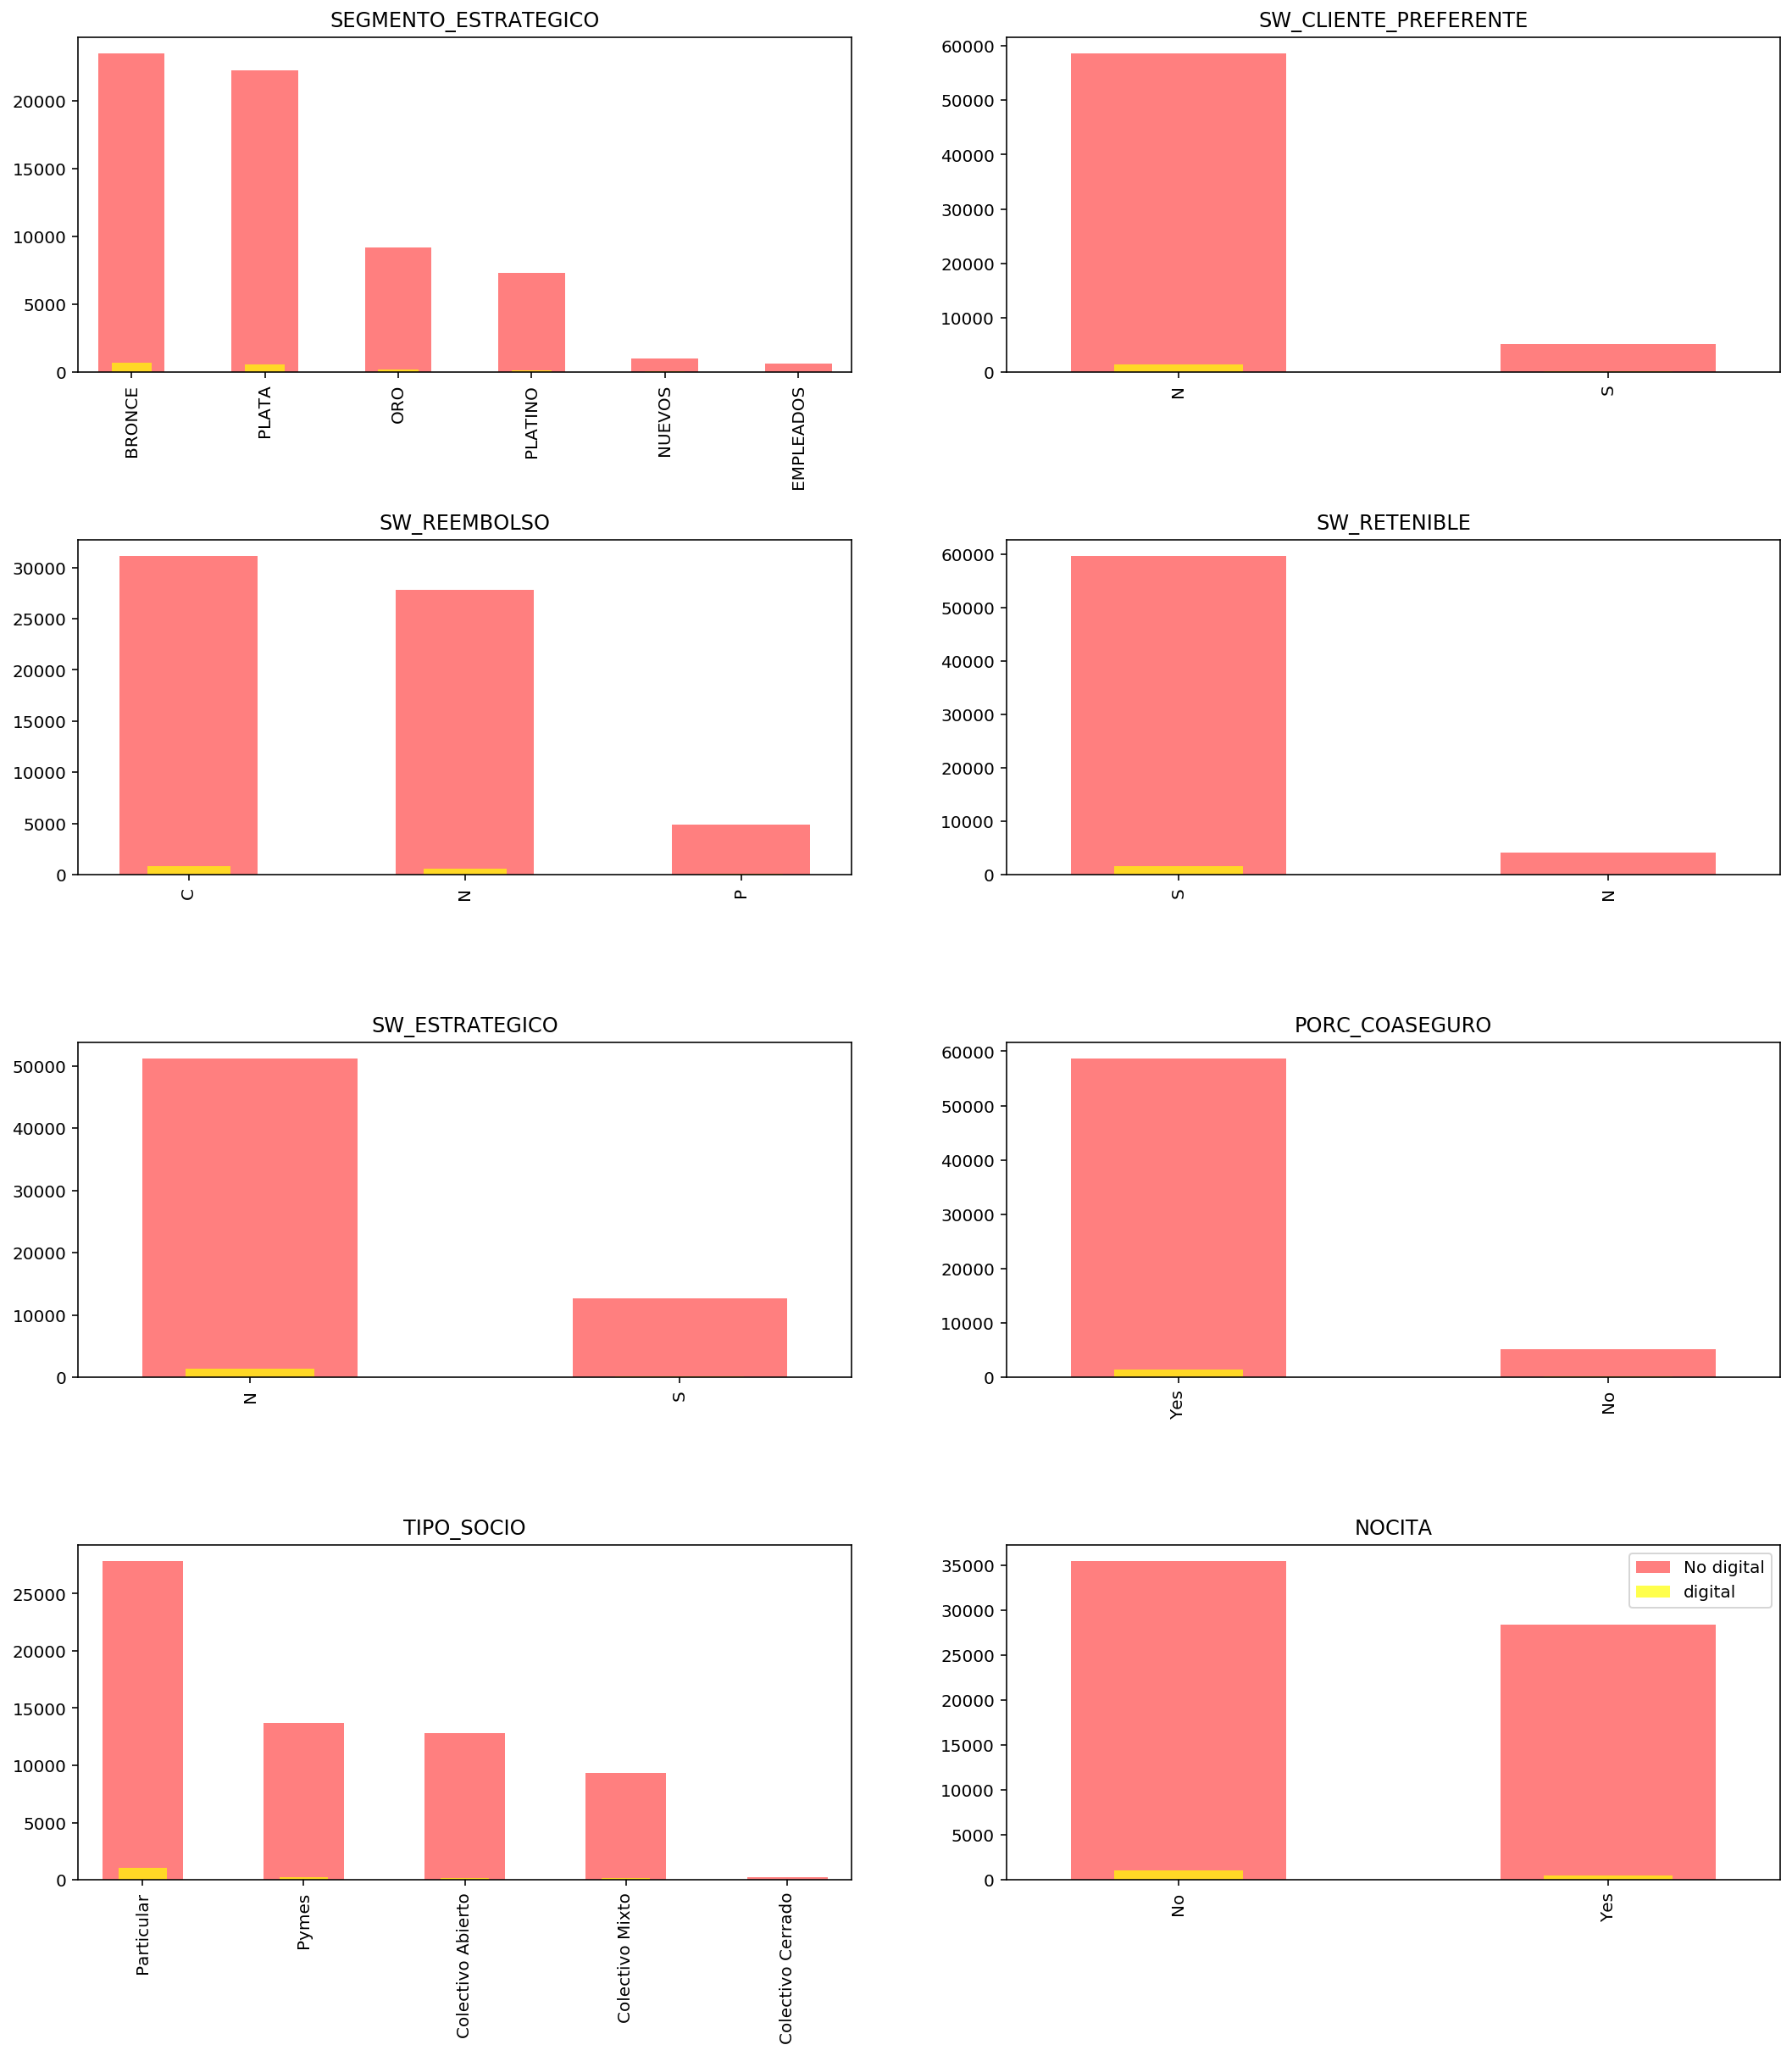

In [16]:
#en este paso quería ver como se distribuia la digitalización en las var categoricas, para ello las meto en una variable y las itero, esto lo que consigue es que cada campo salga reflejado en el grafico
#informandome encontre el truco de meter un campo dentro de otro campo en el histograma lo que me pareció una gran idea
#de esta manera podemos observar como se distribuye la digitalizacion de manera grafica en cada uno de los campos
#la funcion coge las variables y las va iterando de manera que nos va pintando cada histograma de cada campo y luego le he dado el color y el tamaño elegido
var_categoricas = [
 'SEGMENTO_ESTRATEGICO',
 'SW_CLIENTE_PREFERENTE',
 'SW_REEMBOLSO',
 'SW_RETENIBLE',
 'SW_ESTRATEGICO',
 'PORC_COASEGURO',
 'TIPO_SOCIO',
 'NOCITA' ]

ROWS, COLS = 4, 2
fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 20) )
row, col = 0, 0
for i, var_categoricas in enumerate(var_categoricas):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    df[df.DIGITAL=='No'][var_categoricas].value_counts().plot('bar', 
                width=.5, ax=ax[row, col], color='red', alpha=0.5).set_title(var_categoricas)
    df[df.DIGITAL=='Yes'][var_categoricas].value_counts().plot('bar', 
                width=.3, ax=ax[row, col], color='yellow', alpha=0.7).set_title(var_categoricas)
    plt.legend(['No digital', 'digital'])
    fig.subplots_adjust(hspace=0.5)

In [17]:
df.head()


,ANTIGUEDAD,SEGMENTO_ESTRATEGICO,SW_CLIENTE_PREFERENTE,SW_REEMBOLSO,DIGITAL,SW_RETENIBLE,SW_ESTRATEGICO,EDAD,PRIMA,PORC_COASEGURO,TIPO_SOCIO,TIEMPO,TMO,NOCITA
0,2.61,BRONCE,N,N,No,S,N,40.0,498.60,Yes,Pymes,192.0,192.0,No
1,36.78,BRONCE,N,N,No,S,N,37.0,1235.52,Yes,Particular,732.0,366.0,Yes
2,31.00,PLATINO,N,N,No,S,N,86.0,2853.36,Yes,Colectivo Abierto,317.0,317.0,No
3,3.20,BRONCE,N,C,No,S,N,44.0,0.00,Yes,Pymes,284.0,284.0,No
4,56.70,ORO,N,C,No,S,N,57.0,0.00,Yes,Particular,2732.0,683.0,Yes


In [18]:
#Mi intencion es crear nuevos campos y tramificamos poniendo cada campo una serie de tramos gracias a la función cut que mas o menos he elegido consultando los histogramas anteriormente pintados.
tramo_antiguedad=pd.cut(df["ANTIGUEDAD"], bins=[0,5,15,25], labels=['bajo','medio','alto'])

In [19]:
tramo_edad=pd.cut(df["EDAD"], bins=[0,20,40,60], labels=['bajo','medio','alto'])

In [20]:
tramo_prima=pd.cut(df["PRIMA"], bins=[0,250,500,1000], labels=['bajo','medio','alto'])

In [21]:
tramo_tiempo=pd.cut(df["TIEMPO"], bins=[0,250,500,1000], labels=['bajo','medio','alto'])

In [22]:
tramo_tmo=pd.cut(df["TMO"], bins=[0,60,120,300], labels=['bajo','medio','alto'])

In [23]:
tramos =pd.DataFrame([tramo_antiguedad, tramo_edad, tramo_prima,tramo_tiempo,tramo_tmo]).T

In [24]:
#ahora lo que voy a hacer es meter estos tramos en un nuevo dataset quitando las variables numéricas
df2= df.drop(['ANTIGUEDAD', 'EDAD', 'TIEMPO','PRIMA','TMO'], axis=1)

In [25]:
df2.head()

,SEGMENTO_ESTRATEGICO,SW_CLIENTE_PREFERENTE,SW_REEMBOLSO,DIGITAL,SW_RETENIBLE,SW_ESTRATEGICO,PORC_COASEGURO,TIPO_SOCIO,NOCITA
0,BRONCE,N,N,No,S,N,Yes,Pymes,No
1,BRONCE,N,N,No,S,N,Yes,Particular,Yes
2,PLATINO,N,N,No,S,N,Yes,Colectivo Abierto,No
3,BRONCE,N,C,No,S,N,Yes,Pymes,No
4,ORO,N,C,No,S,N,Yes,Particular,Yes


In [26]:
#ahora juntaremos los tramos con el nuevo dataframe gracias a la función concat
data=pd.concat([tramos,df2],axis=1)  
for i in list(data.columns):
    data[i] = pd.Categorical(data[i]) 
dfmodel = pd.get_dummies(data) 

In [27]:
dfmodel.head()

,ANTIGUEDAD_alto,ANTIGUEDAD_bajo,ANTIGUEDAD_medio,EDAD_alto,EDAD_bajo,EDAD_medio,PRIMA_alto,PRIMA_bajo,PRIMA_medio,TIEMPO_alto,...,SW_ESTRATEGICO_S,PORC_COASEGURO_No,PORC_COASEGURO_Yes,TIPO_SOCIO_Colectivo Abierto,TIPO_SOCIO_Colectivo Cerrado,TIPO_SOCIO_Colectivo Mixto,TIPO_SOCIO_Particular,TIPO_SOCIO_Pymes,NOCITA_No,NOCITA_Yes
0,0,1,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,1,0
1,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,1,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
3,0,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1


In [28]:
#Una vez hecho esto nos toca lo que es el análisis en si mismo. spliteamos el df para realizar el entrenamiento
var = dfmodel.drop(["DIGITAL_Yes", "DIGITAL_No"], axis=1).columns
X = dfmodel[var].values
Y = dfmodel["DIGITAL_Yes"].values
validation_size = 0.30
seed = 98
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [29]:
#el siguiente paso es elegir los algoritmos para el modelo, como nos enseñaron cogeremos unos pocos y veremos cual es el mejor.
#
#usando la funcion kfold y cross validation podemos ver cual de los modelos es mas apropiado.
scoring = 'accuracy'
models = []
models.append(('regresión logistica', LogisticRegression()))
models.append(('clasificación de vecinos', KNeighborsClassifier()))
models.append(('arbol de decisión', DecisionTreeClassifier()))
models.append(('ramdon forest', RandomForestClassifier()))
models.append(('naive bayes', GaussianNB()))
results = []
names = []
for name, model in models:
   kfold = model_selection.KFold(n_splits=15, random_state=seed)
   cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
   results.append(cv_results)
   names.append(name)
   final = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
   print(final)

regresión logistica: 0.976328 (0.002327)
clasificación de vecinos: 0.975434 (0.001923)
arbol de decisión: 0.972226 (0.002533)
ramdon forest: 0.972532 (0.002228)
naive bayes: 0.863903 (0.011098)


[]

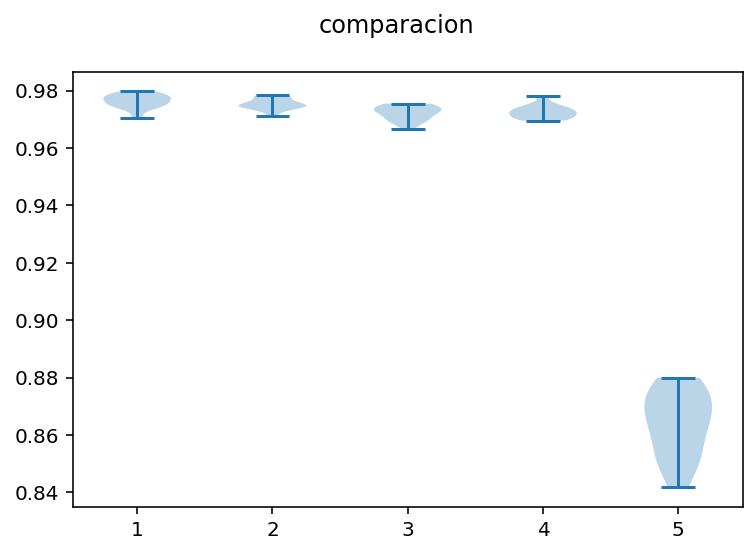

In [30]:
#parece que el mejor algoritmo para este caso es la regresión logistica con un porcentaje de acierto mayor que las otras
#simplemente hago un grafico para verlo mas visual
fig = plt.figure()
fig.suptitle('comparacion')
plt.violinplot(results)
plt.plot()

In [31]:
# Con el modelo desbalanceado conseguimos una buena precision porque los datos están mal tratados, ya que, acierta los no utilizacion de canales digitales pero, al estar los datos
#desbalanceados los numeros estan completamente desproporcionados. Se ve con la curva ROC que a penas acierta un 50% del modelo.
#es por ello que hay que balancear el dataset
model = LogisticRegression()
model.fit(X_train, Y_train)
prediccion = model.predict(X_validation)
print(accuracy_score(Y_validation, prediccion))
print(confusion_matrix(Y_validation, prediccion))
print(classification_report(Y_validation, prediccion))

0.9749032783547139
[[19144    12]
 [  481     7]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19156
           1       0.37      0.01      0.03       488

    accuracy                           0.97     19644
   macro avg       0.67      0.51      0.51     19644
weighted avg       0.96      0.97      0.96     19644



In [32]:
#Calculamos la curva Roc para saber si estamos por encima de la aleatoriedad.
roc_auc = roc_auc_score(Y_validation, prediccion)
print('Curva ROC - AUC del modelo:')
print(roc_auc)

Curva ROC - AUC del modelo:
0.5068589133567705


In [33]:
# Parece que tenemos una buena estimación de alrededor del 80% 
# en primer lugar elegimos el modelo, lo entrenamos y luego hacemos la prediccion en el conjunto de validacion, tras esto sacamos como ha funcionado el modelo "accuracy_score",
#la matriz de confusion para saber como ha ido en cuanto a los falsos negativos o falsos positivos y tener una imagen mas precisa
#tras esto sacamos un resumen de los aspectos mas importahntes del modelo, vemos que tiene un buen rendimiento en detectar los No digitales pero no tan bueno en los digitales
#esto es debido a la falta de muestra, este problema también los tienen los modelos de Fraude, por ejemplo.
#Utilizamos la función balanced para conseguir que el modelo sea mas preciso balanceando el dataset
model = LogisticRegression(class_weight="balanced")
model.fit(X_train, Y_train)
prediccion = model.predict(X_validation)
print(accuracy_score(Y_validation, prediccion))
print(confusion_matrix(Y_validation, prediccion))
print(classification_report(Y_validation, prediccion))


0.7642028100183262
[[14666  4490]
 [  142   346]]
              precision    recall  f1-score   support

           0       0.99      0.77      0.86     19156
           1       0.07      0.71      0.13       488

    accuracy                           0.76     19644
   macro avg       0.53      0.74      0.50     19644
weighted avg       0.97      0.76      0.85     19644



In [34]:
#Calculamos la curva Roc para saber si estamos por encima de la aleatoriedad.
roc_auc = roc_auc_score(Y_validation, prediccion)
print('Curva ROC - AUC del modelo:')
print(roc_auc)

Curva ROC - AUC del modelo:
0.73731254000801


,importancia,campos
37,0.504467,NOCITA_No
1,0.384676,ANTIGUEDAD_bajo
5,0.351795,EDAD_medio


,importancia,campos
38,-0.576132,NOCITA_Yes
11,-0.972833,TIEMPO_medio
10,-1.382029,TIEMPO_bajo


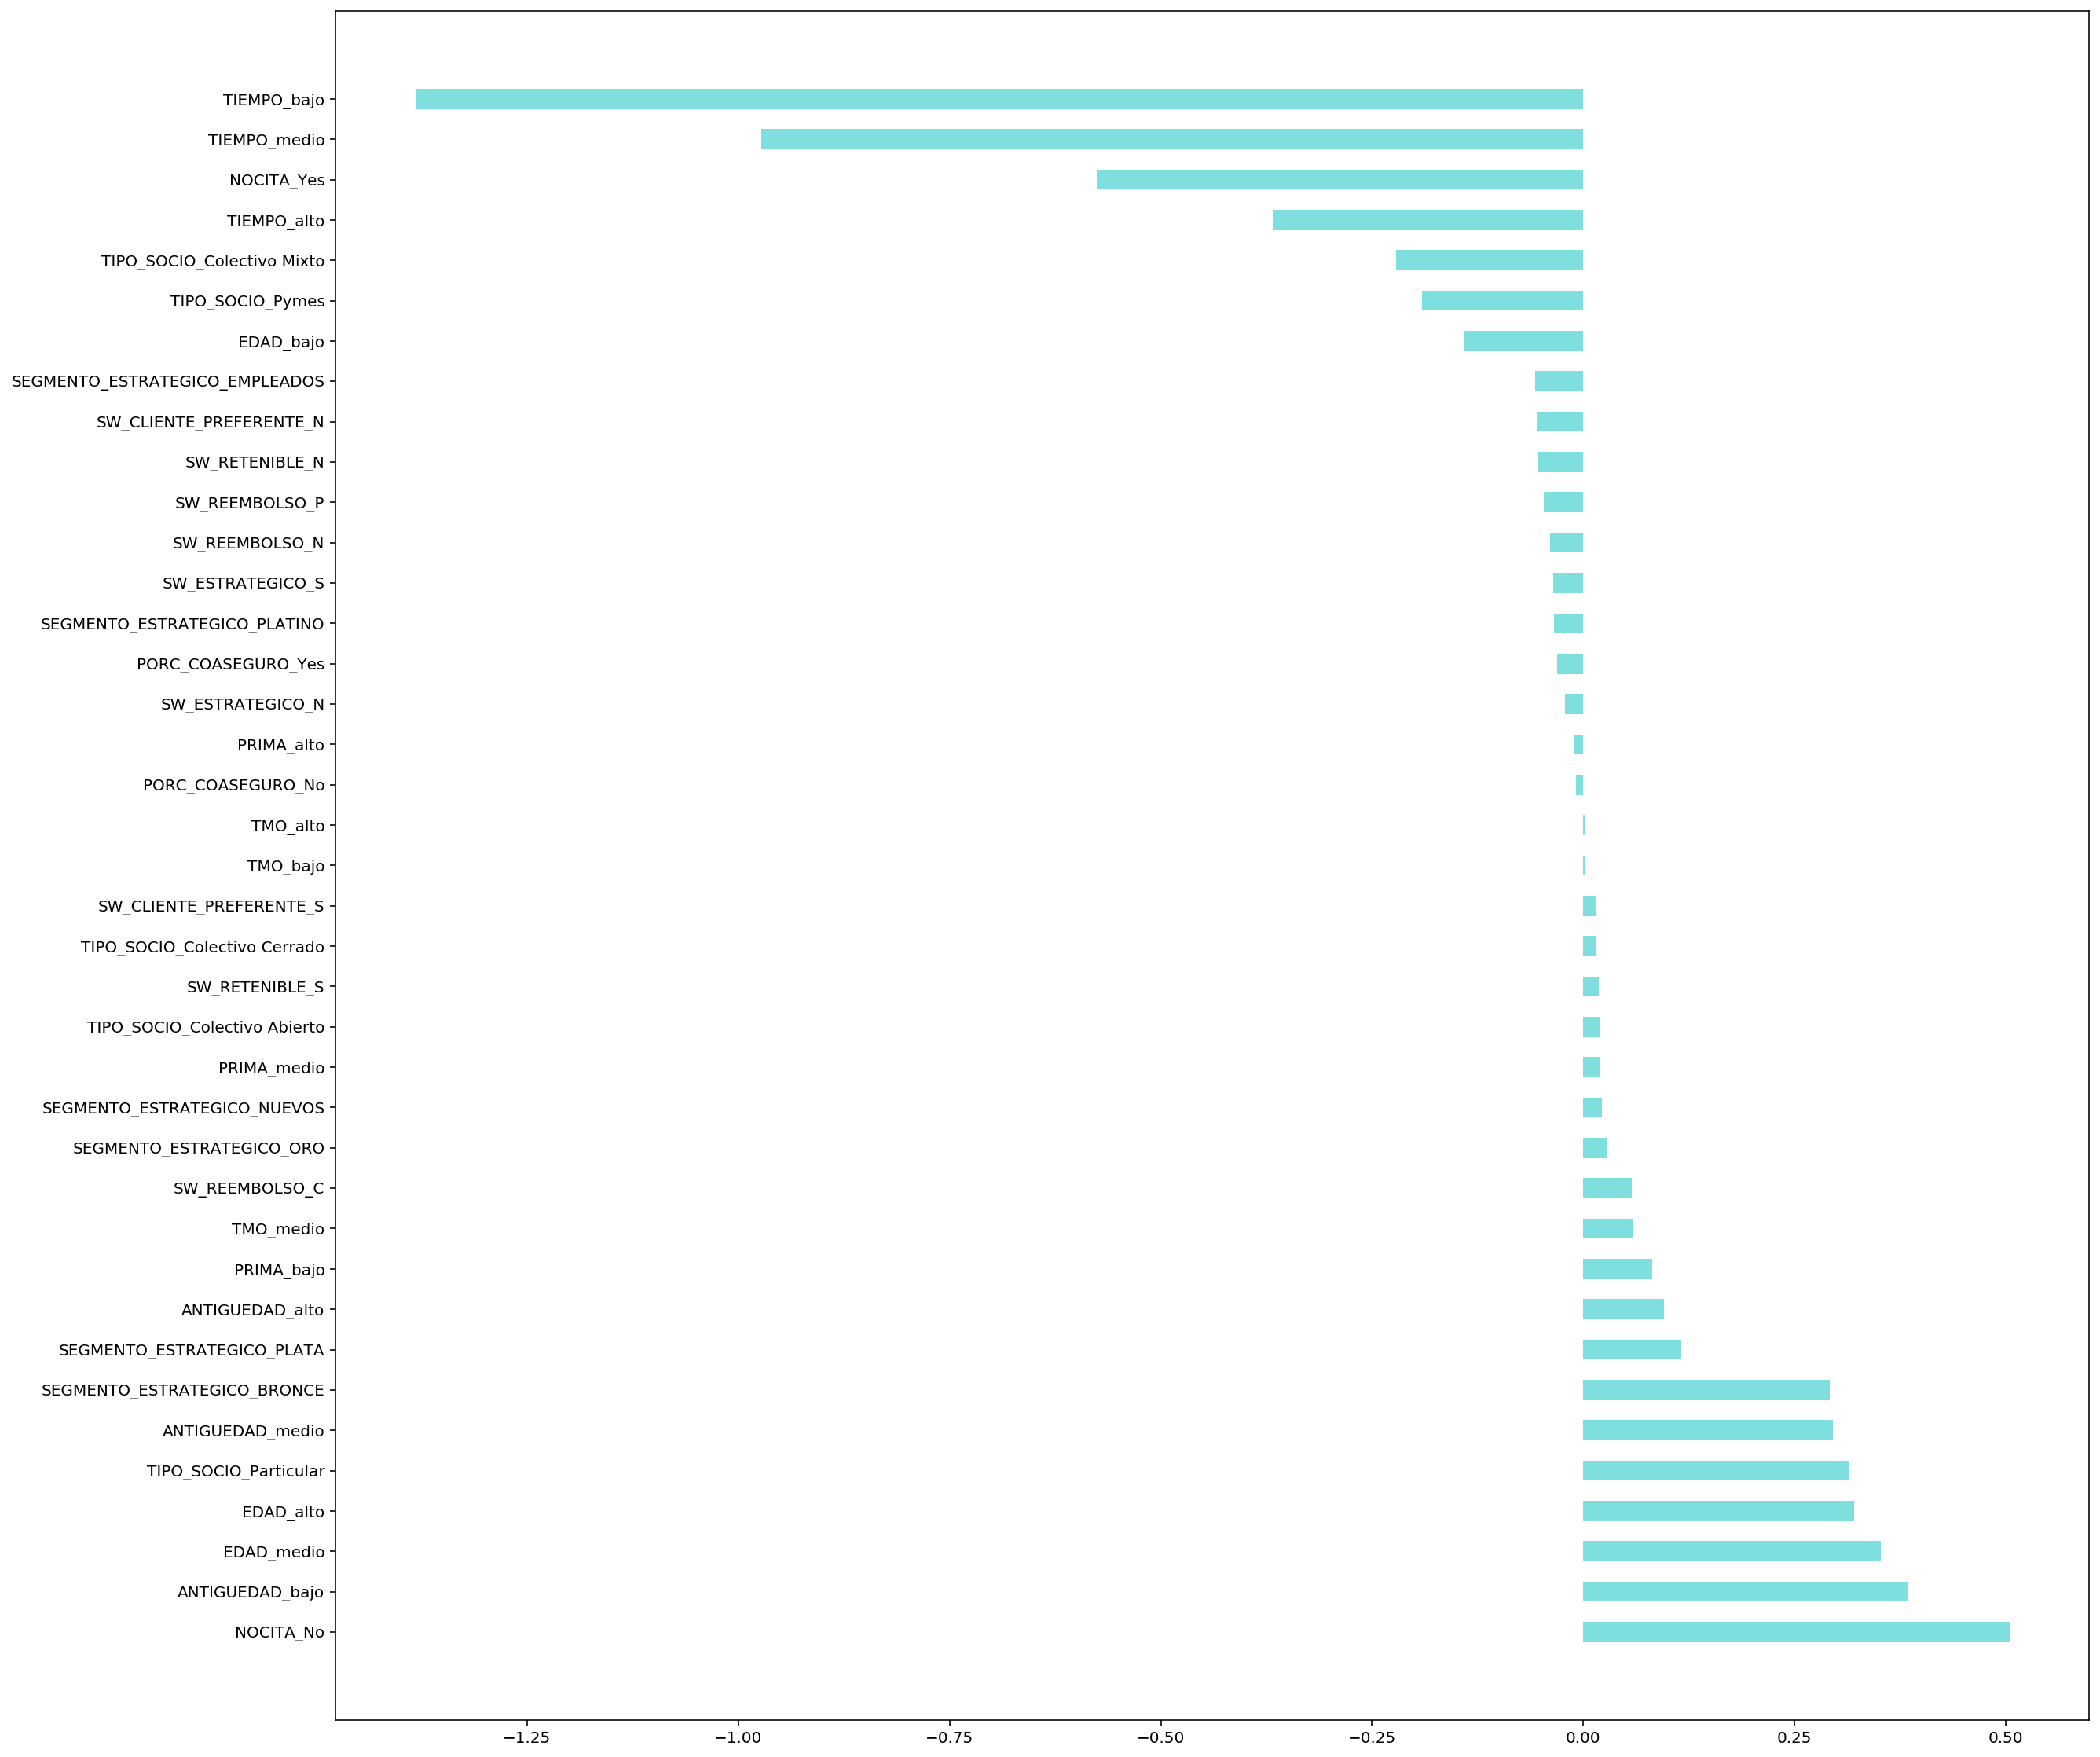

In [35]:
#para mostrar las variables mas importantes para que los clientes decidan utilizar la opcion digital he decidido graficarla, ya que se ve muy bien las variables más importantes de un lado y de otro
#en este paso saco la desviacion y lo comparo con el modelo para tener las cifras que mas pesan en el modelo apra un dato y otro.
#creo un campo llamada importancia y lo pego junto a los campos del dataset y luego simplemente lo ordeno.
#Una vez tenia esos campos de importancia y los campos del datast lo unico que hago es graficarlo para verlo de una manera mas visual.
coef = np.std(X_train, 0)*model.coef_
df_imp = pd.DataFrame(coef).T
df_imp.columns=["importancia"]
df_imp["campos"] = var
df_imp.sort_values("importancia", inplace=True, ascending=False)
display(df_imp.head(3))
display(df_imp.tail(3))

index = np.arange(len(df_imp))
fig = plt.figure(figsize=(20,20))
bar_width = 0.5
rects = plt.barh(index , df_imp["importancia"], bar_width, alpha=0.5, color='c', label='Main')
plt.yticks(index, df_imp["campos"])
plt.show()